# Electric current in conductors: toy model

load the required libraries for calculation and plotting

In [1]:
#%matplotlib inline
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML

Initialise

In [43]:
rnd.seed(None) #make sure random gen does not repeat itself

#model='classic'
model='statistical'

#create a square 2D conductor
w=5e-8 #width in [m]
h=w #height in [m]

#create a set of charge carriers
q=-1.6e-19 #charge of electrons [C]
m=9.1e-31 #electron rest mass [kg]
npart=30 #number of particles in the box
kB=1.38e-23 #Boltzman constant [m^2kgs^-2K-1]
T=300 #absolute temperature [K]
#vth=1e5 #thermal speed of electrons (assume constant here, in reality it is a stochastic variable [m/s], todo: relate to temp 
vth=np.sqrt(3*kB*T/m) #3D electron gas assumed, to be strict there are only 2 degrees of freedom which would turn the '3' into a '2'
l=100e-9 #free path length [m] (depends on purity of materials and density of defects, remember: no material is ever really perfect)
tau=l/vth #free time [s]

Define constant electric field over the box in x direction

In [59]:
ex=8e5 #electric field in x direction [V/m] (note above 1e5 very few materials would survive, but parabolic trajectory becomes hard to notice)
ey=0 #electric field in y direction [V/m]

#create random initial positions of particles
xinit=rnd.random(npart)*w
yinit=rnd.random(npart)*h
thetainit=rnd.random(npart)*2*np.pi #random flight angle in xy plane

Plot the particles in the conductor box

(-5.842383697942347e-10,
 4.9833729057814873e-08,
 1.8490922719555665e-09,
 5.226705969956467e-08)

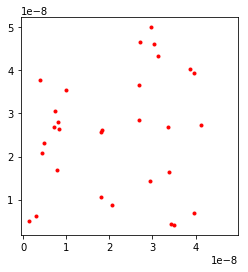

In [60]:
plt.plot(xinit,yinit,'r.')
plt.axis('square')

Run over time (take enough time points to keep accuracy, do convergence test, this depends also on E field)

In [61]:
tpoints=500
tmax=4*tau
t=np.tile(np.linspace(0,tmax,tpoints),[npart,1]) #each particle has its own timescale that gets reset when a collision occurs
x=xinit
y=yinit
theta=thetainit
if (model=='statistical'):
        vx=vth*np.cos(theta)+tau*q*ex/m #assume the particle has a past, it already gained an average acceleration over a time tau (approximate but better than assuming 0)
        vy=vth*np.sin(theta)+tau*q*ey/m
else :
        #(model=='classic'):
        vx=vth*np.cos(theta)+tau*q*ex/(2*m) #assume the particle has a past, it already gained an average acceleration over a time tau (approximate but better than assuming 0)
        vy=vth*np.sin(theta)+tau*q*ey/(2*m)
        
dt=tmax/tpoints

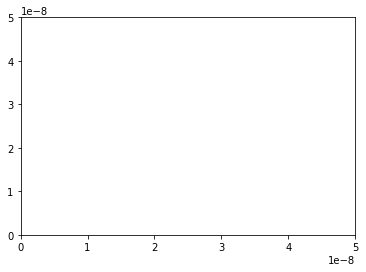

In [93]:
jx=np.zeros(tpoints)
jy=np.zeros(tpoints)

#for animation
fig, ax = plt.subplots()
line1, = ax.plot([],[],'r.')
line1.set_antialiased(True)
line2, = ax.plot([],[],'b*') #when collision show blue start
line2.set_antialiased(True)
#for afterglow effect to better follow track of particles
line11, = ax.plot([],[],'r.')
line11.set_color((1,0.2,0.2))
line11.set_antialiased(True)
line12, = ax.plot([],[],'r.')
line12.set_color((1,0.4,0.4))
line12.set_antialiased(True)
line13, = ax.plot([],[],'r.')
line13.set_color((1,0.6,0.6))
line13.set_antialiased(True)
line14, = ax.plot([],[],'r.')
line14.set_color((1,0.8,0.8))
line14.set_antialiased(True)
#scoreboard=ax.text(w/2,3*h/4,'') 

xframe=np.zeros((tpoints,npart))
yframe=np.zeros((tpoints,npart))
cframe=np.zeros((tpoints,npart))

def init():  # only required for blitting to give a clean slate.
    line1.set_data([], [])
    line11.set_data([], [])
    line12.set_data([], [])
    line13.set_data([], [])
    line14.set_data([], [])
    line2.set_data([], [])
    
    ax.set_xlim(( 0, w))
    ax.set_ylim(( 0, h))
    return (line1,line2,line11,line12,)

def animate(i,xframe,yframe,cframe,hitlistleft,hitlistright):   
    #add some afterglow by plotting previous positions with transparancy
    if (i>=4):
        collid=np.where(cframe[i,:])
        line2.set_xdata(xframe[i,collid])  # update the data and with another marker for the colliding points
        line2.set_ydata(yframe[i,collid]) 
        nocollid=np.where(cframe[i,:]==0)
        line1.set_xdata(xframe[i,nocollid])  # update the data for the non-colliding points
        line1.set_ydata(yframe[i,nocollid]) 
        nocollid=np.where(cframe[i-1,:]==0)
        collid=np.where(cframe[i-1,:])
        line11.set_xdata(xframe[i-1,nocollid])  # update the data for the non-colliding points
        line11.set_ydata(yframe[i-1,nocollid])       
        nocollid=np.where(cframe[i-2,:]==0)
        collid=np.where(cframe[i-2,:])
        line12.set_xdata(xframe[i-2,nocollid])  # update the data for the non-colliding points
        line12.set_ydata(yframe[i-2,nocollid])
        nocollid=np.where(cframe[i-3,:]==0)
        collid=np.where(cframe[i-3,:])
        line13.set_xdata(xframe[i-3,nocollid])  # update the data for the non-colliding points
        line13.set_ydata(yframe[i-3,nocollid])
        nocollid=np.where(cframe[i-4,:]==0)
        collid=np.where(cframe[i-4,:])
        line14.set_xdata(xframe[i-4,nocollid])  # update the data for the non-colliding points
        line14.set_ydata(yframe[i-4,nocollid])
    #scoreboard.set_text( str(hitlistleft[i])+ '/' + str(hitlistright[i])  )      
    return (line1,line2,line11,line12,)
hitleft=0
hitright=0
hitlistleft=np.zeros(tpoints)
hitlistright=np.zeros(tpoints)
for tid in range(tpoints):
    #calculate new point some time later   
    x=x+vx*dt
    y=y+vy*dt
    #and acceleration term due to E field
    vx=vx+np.ones(vx.shape)*dt*q*ex/m
    vy=vy+np.ones(vy.shape)*dt*q*ey/m
    
    #calculate current
    jx[tid]=npart*q*np.mean(vx) #instantenous current (note the random fluctuation which should get less for more particles)
    jy[tid]=npart*q*np.mean(vy) #instantenous current (note the random fluctuation which should get less for more particles)
    
    #check if they hit the wall and keep them inside box by modulo
    hitleft=hitleft+len(np.where(x<0)) #keep track of the nr of particles flying through the left boundary
    hitright=hitright+len(np.where(x>w)) #and to the right boundary
    hitlistleft[tid]=hitleft
    hitlistright[tid]=hitright
    
    
    x=np.remainder(x,w) #particle that dissapear through top wall will reappear bottom to keep nr of particles constant
    y=np.remainder(y,h) #particle that dissapear through right wall will reappear left to keep nr of particles constant
    
    
    #reset speed and direction in case a collision with impurity occurs
    if (model=='statistical'):
            #careful with this formula, contains statistical difficulties,
            #as we do a statistical draw in each time point which needs to
            #be compensated (otherwise more time points would lead to
            #faster collision)        
            draw=np.exp(np.divide(-t[:,tid],tau*(t[:,tid]/dt + np.ones(npart)) )) #a vector with indices for those particles that have a collision now (statistical model for exponential chance of colliding)
            collision=(rnd.random(npart)>draw)                                    
    else:
            #classical model
            collision=t[:,tid]>(tau*np.ones(npart))
    collidt=np.where(collision) #classical collision all collide when t==tau            
    if (collidt[0].size>0) :  
            collid=collidt[0]
            np.mean(t[collid,tid]) #should be close to tau if statistics is correct                                       
            t1=t[collid,tid]
            tnow=np.repeat(t1[:,np.newaxis],tpoints,1)                        
            t[collid,:]=t[collid,:]-tnow #reset time to zero for those particles that had a collision
            theta[collid]=rnd.random(theta[collid].shape)*2*np.pi #new angle for those particles that had a collision
            vx[collid]=np.multiply(vth,np.cos(theta[collid])) #in case of collision take new speed, otherwise keep old speed
            vy[collid]=np.multiply(vth,np.sin(theta[collid]))
            cframe[tid,collid]=1
    xframe[tid,:]=x
    yframe[tid,:]=y
    
ani = animation.FuncAnimation(fig, animate, init_func=init, fargs=(xframe,yframe,cframe,hitlistleft,hitlistright), interval=100,frames=range(4,tpoints), blit=True)
plt.draw()
plt.show()  

Now make a html movie out of it (this takes a while). A particle flashes blue when a collision occurs.

In [95]:
#save as animated gif if wanted (takes long time)
#ani.save('currentmodel.gif', writer='imagemagick')

In [94]:
HTML(ani.to_jshtml())

Note how the particles move in all directions but are accelerated to the left (for Ex positive as electrons are negative). Every time a collision occurs, the particle flashes blue and changes direction randomly. For the statistical model collisions occur randomly, for the classical model all collisions happen at the same time (tau).
To be clear: with collision we mean collision with an impurity (not displayed and not fixed in one location) and we assume there are no collisions between the particles.
Note how movement to the left results in higher speed particles (they get a longer afterglow tail in the plot). This represents the net current flowing towards the left (at least for Ex positive). Indeed the total number of particles leaving through either wall is the same (the number of particles remains constant) but their speed is not.

In [ ]:
j=np.mean(jx)
sigma=np.mean(jx)/ex #conductivity estimate (with stochastic noise)
mu=sigma/(npart*q) #mobility estimate

Now we can estimate the current from averaging over all particles (current is a statistical variable). The we can compare with analytical results from course notes, which should roughly agree with the statistical results (depending on whether we used the 'statistical' or 'classical' model.

In [ ]:
mus=q*tau/m 
sigmas=npart*q**2*tau/m 
muc=q*tau/(2*m) 
sigmac=npart*q**2*tau/(2*m) 

In [ ]:
plt.plot(t[1,:],jx,'b',label='Jx')
plt.plot(t[1,:],sigmas*ex*np.ones(jx.shape),'r',label='statistical prediction')
plt.plot(t[1,:],sigmac*ex*np.ones(jx.shape),'g',label='classical prediction')
plt.title('instantenous current')
plt.xlabel('t')
plt.ylabel('J')
plt.legend()

Now try with very high fields (e.g. >1e5 V/m) and see if Ohms law still applies (linear relation between field and current). 
Also if the box is small with respect to the mean path, we get so-called balistic transport with a highly nonlinear behaviour.
In both cases, the stochastic blue line will be higher than the analytical results as the approximations don't hold anymore. Both situation occur in reality as well, so our model at least captures the essential physics.
